In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
#import datasets
import numpy as np

pl.seed_everything(89026614)

#text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614


In [5]:
device = "mps"
block_size = 256
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [6]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=60, num_layers=5):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size, dtype=torch.bool)))
        t = torch.arange(-block_size, 0)
        self.register_buffer("alibi", torch.tril(torch.cat([t, t[:-1]]).unfold(0, len(t), 1).flip(0)))

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        w = q @ k.transpose(-2, -1)
        w = w + self.alibi[:T, :T]
        w.masked_fill_(self.mask[:T, :T], float("-Inf"))
        w = F.softmax(w, dim=-1)
        attn = w @ v

        x = x + attn
        x = x + self.mlp(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=40, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 210 K 
-------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 209/209 [00:08<00:00, 25.90it/s, loss=1.51, v_num=227, test_loss=1.560]And now of them toped to the restuck of saying him in them.


"That all
Epoch 3: 100%|██████████| 209/209 [00:08<00:00, 25.90it/s, loss=1.46, v_num=227, test_loss=1.540]And now the land. I don't looked too."

"I came out." Monkear."

He loo
Epoch 11: 100%|██████████| 209/209 [00:08<00:00, 25.80it/s, loss=1.3, v_num=227, test_loss=1.330] And now they were soul get me.'

"'I'll talk she and turned,'s  in thei
Epoch 12: 100%|██████████| 209/209 [00:08<00:00, 25.69it/s, loss=1.29, v_num=227, test_loss=1.360]And now. Why is full, but it went backs of more.

"No, what did, not a 
Epoch 15: 100%|██████████| 209/209 [00:08<00:00, 24.72it/s, loss=1.25, v_num=227, test_loss=1.290]And now so.

She was a little boy, and I sup steps, soft. Wait if she h
Epoch 26: 100%|██████████| 209/209 [00:10<00:00, 19.28it/s, loss=1.22, v_num=227, test_loss=1.240]And now had mouse the flower-state.

Where show he was

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 209/209 [00:11<00:00, 17.78it/s, loss=1.16, v_num=227, test_loss=1.190]


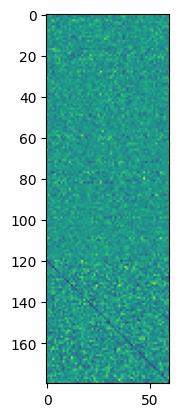

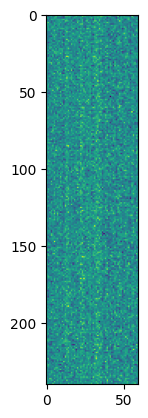

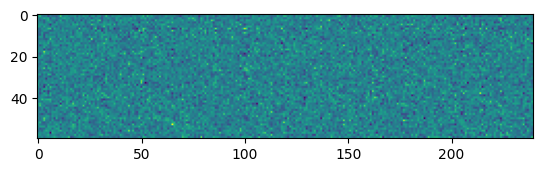

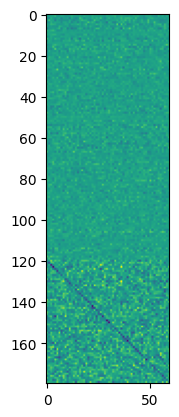

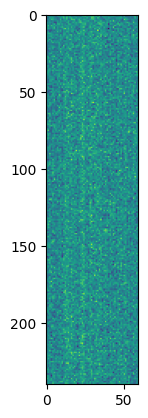

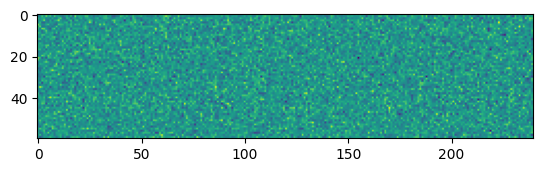

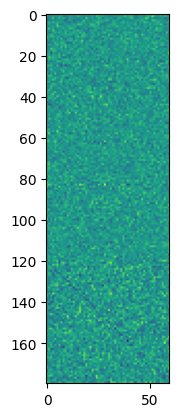

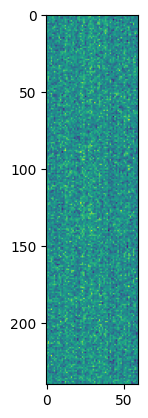

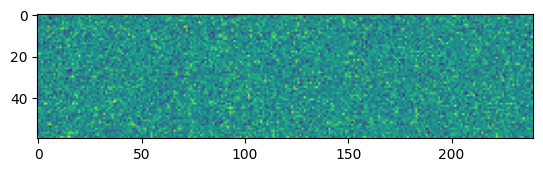

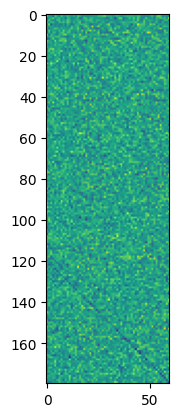

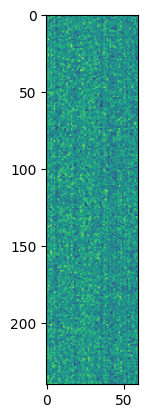

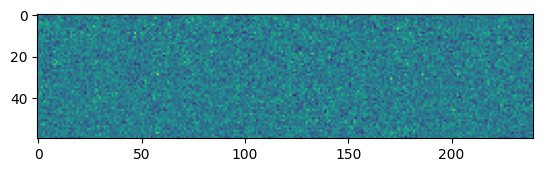

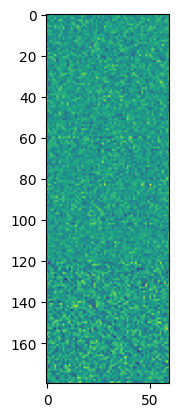

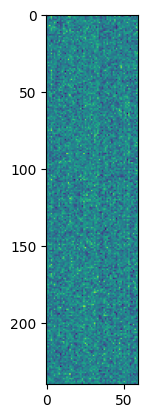

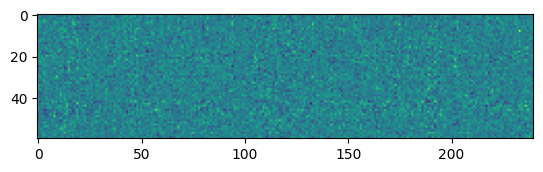

In [8]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.qkv.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [9]:
print(model.generate("O God, O God!", 1024))

O God, O God! You are it waiting boy."

"I guess I'm going to the woods to scrattle only children wull be a good way back of them that my farther. Water had a belong in that stand over to a long bunny uncle.  As Mid Polly and ask the mam splashes, which is coming. But, if you were impocking strapped by stay here, but how his clean way."

Bunny came for it. "Oh, dear!" cried Bushy. "It's no bark from mark third beatering. But he threw it in the capes, the lion."

"Why, you'll try him, inside their sticks once not believe the fisherman, and they all poor money white covels and he heard on boards out of this, which we seem to be a spoke carefully and she was a fire-house. I will take you we'll be stay there shall much told whether to make my lips," he threw struck.

"I want my cage."

Mother and Margy, but I know you may not for that had decided. There they had better the shown in still high things, as that the bad boy said, "But you want!"

To make sure that was about him."

"There he di